In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from sklearn.preprocessing import Normalizer

In [2]:
#import the data
pd.set_option('max_column', None)
pd.set_option('display.float_format', lambda x: '%.0f' % x)
original_data=pd.read_csv("D:/Stella/Documents/10_Academy/Week_1/Week-1/data/Week1_challenge_data.csv")
data=original_data.copy()
data.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),DL TP < 50 Kbps (%),50 Kbps < DL TP < 250 Kbps (%),250 Kbps < DL TP < 1 Mbps (%),DL TP > 1 Mbps (%),UL TP < 10 Kbps (%),10 Kbps < UL TP < 50 Kbps (%),50 Kbps < UL TP < 300 Kbps (%),UL TP > 300 Kbps (%),HTTP DL (Bytes),HTTP UL (Bytes),Activity Duration DL (ms),Activity Duration UL (ms),Dur. (ms).1,Handset Manufacturer,Handset Type,Nb of sec with 125000B < Vol DL,Nb of sec with 1250B < Vol UL < 6250B,Nb of sec with 31250B < Vol DL < 125000B,Nb of sec with 37500B < Vol UL,Nb of sec with 6250B < Vol DL < 31250B,Nb of sec with 6250B < Vol UL < 37500B,Nb of sec with Vol DL < 6250B,Nb of sec with Vol UL < 1250B,Social Media DL (Bytes),Social Media UL (Bytes),Google DL (Bytes),Google UL (Bytes),Email DL (Bytes),Email UL (Bytes),Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,13114483460844900352,4/4/2019 12:01,770,4/25/2019 14:35,662,1823652,208201448079117,33664962239,35521209507511,9.16456699548519E+015,42,5,23,44,NaN,NaN,100,0,0,0,100,0,0,0,NaN,NaN,37624,38787,1823652892,Samsung,Samsung Galaxy A5 Sm-A520F,NaN,NaN,NaN,NaN,NaN,NaN,213,214,1545765,24420,1634479,1271433,3563542,137762,15854611,2501332,8198936,9656251,278082303,14344150,171744450,8814393,36749741,308879636
1,13114483482878900224,4/9/2019 13:04,235,4/25/2019 8:15,606,1365104,208201909211140,33681854413,35794009006359,L77566A,65,5,16,26,NaN,NaN,100,0,0,0,100,0,0,0,NaN,NaN,168,3560,1365104371,Samsung,Samsung Galaxy J5 (Sm-J530),NaN,NaN,NaN,NaN,NaN,NaN,971,1022,1926113,7165,3493924,920172,629046,308339,20247395,19111729,18338413,17227132,608750074,1170709,526904238,15055145,53800391,653384965
2,13114483484080500736,4/9/2019 17:42,1,4/25/2019 11:58,652,1361762,208200314458056,33760627129,35281510359387,D42335A,NaN,NaN,6,9,NaN,NaN,100,0,0,0,100,0,0,0,NaN,NaN,0,0,1361762651,Samsung,Samsung Galaxy A8 (2018),NaN,NaN,NaN,NaN,NaN,NaN,751,695,1684053,42224,8535055,1694064,2690151,672973,19725661,14699576,17587794,6163408,229584621,395630,410692588,4215763,27883638,279807335
3,13114483485442799616,4/10/2019 0:31,486,4/25/2019 7:36,171,1321509,208201402342131,33750343200,35356610164913,T21824A,NaN,NaN,44,44,NaN,NaN,100,0,0,0,100,0,0,0,NaN,NaN,3330,37882,1321509685,undefined,undefined,NaN,NaN,NaN,NaN,NaN,NaN,17,207,644121,13372,9023734,2788027,1439754,631229,21388122,15146643,13994646,1097942,799538153,10849722,749039933,12797283,43324218,846028530
4,13114483499480700928,4/12/2019 20:10,565,4/25/2019 10:40,954,1089009,208201401415120,33699795932,35407009745539,D88865A,NaN,NaN,6,9,NaN,NaN,100,0,0,0,100,0,0,0,NaN,NaN,0,0,1089009389,Samsung,Samsung Sm-G390F,NaN,NaN,NaN,NaN,NaN,NaN,607,604,862600,50188,6248284,1500559,1936496,173853,15259380,18962873,17124581,415218,527707248,3529801,550709500,13910322,38542814,569138589


In [ ]:
# column names in the dataset
data.columns.tolist()

In [ ]:
# number of data points
print(f" There are {data.shape[0]} rows and {data.shape[1]} columns")

# Check for missing values

In [ ]:
#total values missing in the dataset as a numerical value and as a percentage
# how many missing values exist or better still what is the % of missing values in the dataset?
def percent_missing(df):

    # Calculate total number of cells in dataframe
    totalCells = np.product(df.shape)

    # Count number of missing values per column
    missingCount = df.isnull().sum()

    # Calculate total number of missing values
    totalMissing = missingCount.sum()

    # Calculate percentage of missing values
    print("The Telco dataset contains", totalMissing," missing values or", round(((totalMissing/totalCells) * 100), 2), "%", "of the dataset.")

percent_missing(data)

In [3]:
#Total percent of missing values per column
def missing_per_column(df):
    print(round((df.isna().sum()*100)/len(df), 2))
missing_per_column(data)

Bearer Id                                   1
Start                                       0
Start ms                                    0
End                                         0
End ms                                      0
Dur. (ms)                                   0
IMSI                                        0
MSISDN/Number                               1
IMEI                                        0
Last Location Name                          1
Avg RTT DL (ms)                            19
Avg RTT UL (ms)                            19
Avg Bearer TP DL (kbps)                     0
Avg Bearer TP UL (kbps)                     0
TCP DL Retrans. Vol (Bytes)                59
TCP UL Retrans. Vol (Bytes)                64
DL TP < 50 Kbps (%)                         0
50 Kbps < DL TP < 250 Kbps (%)              0
250 Kbps < DL TP < 1 Mbps (%)               0
DL TP > 1 Mbps (%)                          0
UL TP < 10 Kbps (%)                         1
10 Kbps < UL TP < 50 Kbps (%)     

# Handling Missing Data
Missing values in the categorical columns will be replaced using the mode while the mean will be used for quantitative columns.
The histogram below shows some columns are skewed that may make the mean unsuitable for handling missing values.
However, the mean is used because the dataset will be normalized to make the values follow a normal distribution

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

def exploratory_hist(df):
    df.hist(figsize=(15,15), layout=(11,5))
plt.show()
exploratory_hist(data)

In [ ]:
#plots = {i: px.histogram(data, x=i,) for i in data.columns}

In [ ]:
#plots['Bearer Id']

# Normalizing the data

In [12]:
#impute missing values using the mean and mode
def impute(df):
    cat_list=['Bearer Id','Start','End','IMSI','MSISDN/Number','IMEI','Last Location Name','Handset Manufacturer','Handset Type']
    for i in df.columns:
        if i not in cat_list:
            df[i]=df[i].fillna(df[i].mean())
        else:
            df[i]=df[i].fillna(df[i].value_counts().index[0])
    return df

In [13]:
impute(data).head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),DL TP < 50 Kbps (%),50 Kbps < DL TP < 250 Kbps (%),250 Kbps < DL TP < 1 Mbps (%),DL TP > 1 Mbps (%),UL TP < 10 Kbps (%),10 Kbps < UL TP < 50 Kbps (%),50 Kbps < UL TP < 300 Kbps (%),UL TP > 300 Kbps (%),HTTP DL (Bytes),HTTP UL (Bytes),Activity Duration DL (ms),Activity Duration UL (ms),Dur. (ms).1,Handset Manufacturer,Handset Type,Nb of sec with 125000B < Vol DL,Nb of sec with 1250B < Vol UL < 6250B,Nb of sec with 31250B < Vol DL < 125000B,Nb of sec with 37500B < Vol UL,Nb of sec with 6250B < Vol DL < 31250B,Nb of sec with 6250B < Vol UL < 37500B,Nb of sec with Vol DL < 6250B,Nb of sec with Vol UL < 1250B,Social Media DL (Bytes),Social Media UL (Bytes),Google DL (Bytes),Google UL (Bytes),Email DL (Bytes),Email UL (Bytes),Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,13114483460844900352,4/4/2019 12:01,770,4/25/2019 14:35,662,1823652,208201448079117,33664962239,35521209507511,9.16456699548519E+015,42,5,23,44,20809914,759659,100,0,0,0,100,0,0,0,114471024,3242301,37624,38787,1823652892,Samsung,Samsung Galaxy A5 Sm-A520F,990,340,811,149,965,141,213,214,1545765,24420,1634479,1271433,3563542,137762,15854611,2501332,8198936,9656251,278082303,14344150,171744450,8814393,36749741,308879636
1,13114483482878900224,4/9/2019 13:04,235,4/25/2019 8:15,606,1365104,208201909211140,33681854413,35794009006359,L77566A,65,5,16,26,20809914,759659,100,0,0,0,100,0,0,0,114471024,3242301,168,3560,1365104371,Samsung,Samsung Galaxy J5 (Sm-J530),990,340,811,149,965,141,971,1022,1926113,7165,3493924,920172,629046,308339,20247395,19111729,18338413,17227132,608750074,1170709,526904238,15055145,53800391,653384965
2,13114483484080500736,4/9/2019 17:42,1,4/25/2019 11:58,652,1361762,208200314458056,33760627129,35281510359387,D42335A,110,18,6,9,20809914,759659,100,0,0,0,100,0,0,0,114471024,3242301,0,0,1361762651,Samsung,Samsung Galaxy A8 (2018),990,340,811,149,965,141,751,695,1684053,42224,8535055,1694064,2690151,672973,19725661,14699576,17587794,6163408,229584621,395630,410692588,4215763,27883638,279807335
3,13114483485442799616,4/10/2019 0:31,486,4/25/2019 7:36,171,1321509,208201402342131,33750343200,35356610164913,T21824A,110,18,44,44,20809914,759659,100,0,0,0,100,0,0,0,114471024,3242301,3330,37882,1321509685,undefined,undefined,990,340,811,149,965,141,17,207,644121,13372,9023734,2788027,1439754,631229,21388122,15146643,13994646,1097942,799538153,10849722,749039933,12797283,43324218,846028530
4,13114483499480700928,4/12/2019 20:10,565,4/25/2019 10:40,954,1089009,208201401415120,33699795932,35407009745539,D88865A,110,18,6,9,20809914,759659,100,0,0,0,100,0,0,0,114471024,3242301,0,0,1089009389,Samsung,Samsung Sm-G390F,990,340,811,149,965,141,607,604,862600,50188,6248284,1500559,1936496,173853,15259380,18962873,17124581,415218,527707248,3529801,550709500,13910322,38542814,569138589


In [16]:
def normalizer(df):
    df_new=df.drop(['Bearer Id','Start','End','IMSI','MSISDN/Number','IMEI','Last Location Name','Handset Manufacturer','Handset Type'],axis=1)
    norm = Normalizer()
    # normalize the data with boxcox
    normalized_data = norm.fit_transform(df_new)
    normalized_df=pd.DataFrame(normalized_data,columns = df_new.columns)
    final_df=pd.merge(df,normalized_df, how='right')
    return final_df
    #final_df.hist(figsize=(15,15), layout=(11,5))
    
normalizer(impute(data))

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),DL TP < 50 Kbps (%),50 Kbps < DL TP < 250 Kbps (%),250 Kbps < DL TP < 1 Mbps (%),DL TP > 1 Mbps (%),UL TP < 10 Kbps (%),10 Kbps < UL TP < 50 Kbps (%),50 Kbps < UL TP < 300 Kbps (%),UL TP > 300 Kbps (%),HTTP DL (Bytes),HTTP UL (Bytes),Activity Duration DL (ms),Activity Duration UL (ms),Dur. (ms).1,Handset Manufacturer,Handset Type,Nb of sec with 125000B < Vol DL,Nb of sec with 1250B < Vol UL < 6250B,Nb of sec with 31250B < Vol DL < 125000B,Nb of sec with 37500B < Vol UL,Nb of sec with 6250B < Vol DL < 31250B,Nb of sec with 6250B < Vol UL < 37500B,Nb of sec with Vol DL < 6250B,Nb of sec with Vol UL < 1250B,Social Media DL (Bytes),Social Media UL (Bytes),Google DL (Bytes),Google UL (Bytes),Email DL (Bytes),Email UL (Bytes),Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,NaN,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,NaN,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,NaN,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,NaN,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,NaN,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149996,NaN,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
149997,NaN,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
149998,NaN,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
149999,NaN,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


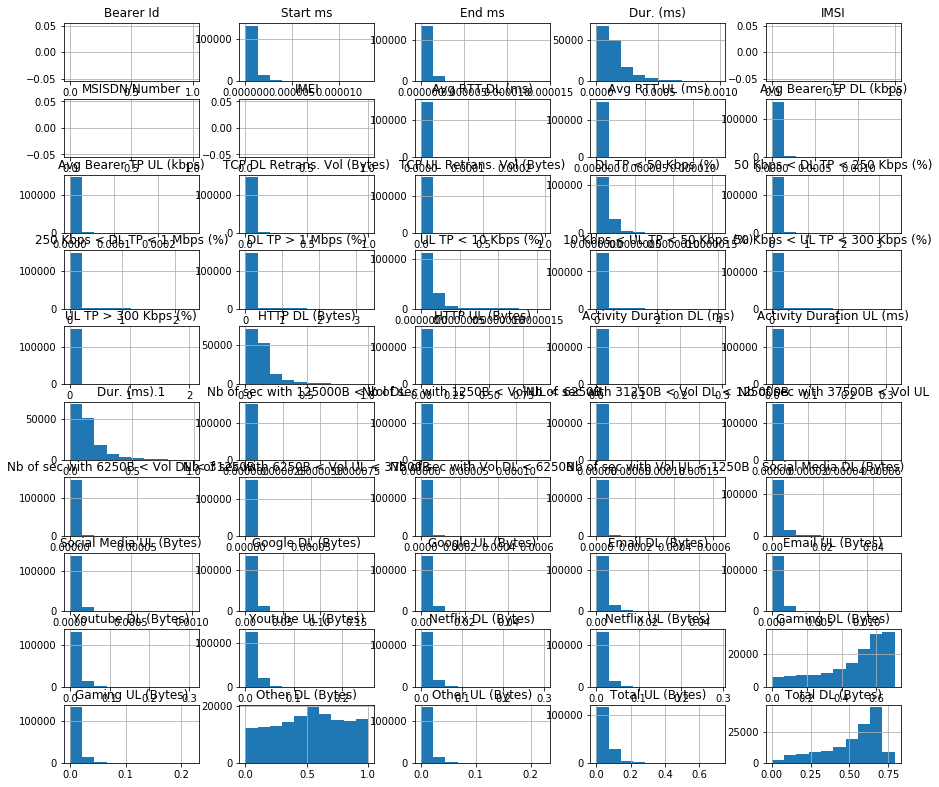

In [17]:
exploratory_hist(normalizer(impute(data)))

# Check data types

In [18]:
#Convert start and end to date time
def date_time(df):
    df['Start']=pd.to_datetime(df['Start'], infer_datetime_format=True)
    df['End']=pd.to_datetime(df['End'], infer_datetime_format=True)
    return df
date_time(impute(data)).head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),DL TP < 50 Kbps (%),50 Kbps < DL TP < 250 Kbps (%),250 Kbps < DL TP < 1 Mbps (%),DL TP > 1 Mbps (%),UL TP < 10 Kbps (%),10 Kbps < UL TP < 50 Kbps (%),50 Kbps < UL TP < 300 Kbps (%),UL TP > 300 Kbps (%),HTTP DL (Bytes),HTTP UL (Bytes),Activity Duration DL (ms),Activity Duration UL (ms),Dur. (ms).1,Handset Manufacturer,Handset Type,Nb of sec with 125000B < Vol DL,Nb of sec with 1250B < Vol UL < 6250B,Nb of sec with 31250B < Vol DL < 125000B,Nb of sec with 37500B < Vol UL,Nb of sec with 6250B < Vol DL < 31250B,Nb of sec with 6250B < Vol UL < 37500B,Nb of sec with Vol DL < 6250B,Nb of sec with Vol UL < 1250B,Social Media DL (Bytes),Social Media UL (Bytes),Google DL (Bytes),Google UL (Bytes),Email DL (Bytes),Email UL (Bytes),Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,13114483460844900352,2019-04-04 12:01:00,770,2019-04-25 14:35:00,662,1823652,208201448079117,33664962239,35521209507511,9.16456699548519E+015,42,5,23,44,20809914,759659,100,0,0,0,100,0,0,0,114471024,3242301,37624,38787,1823652892,Samsung,Samsung Galaxy A5 Sm-A520F,990,340,811,149,965,141,213,214,1545765,24420,1634479,1271433,3563542,137762,15854611,2501332,8198936,9656251,278082303,14344150,171744450,8814393,36749741,308879636
1,13114483482878900224,2019-04-09 13:04:00,235,2019-04-25 08:15:00,606,1365104,208201909211140,33681854413,35794009006359,L77566A,65,5,16,26,20809914,759659,100,0,0,0,100,0,0,0,114471024,3242301,168,3560,1365104371,Samsung,Samsung Galaxy J5 (Sm-J530),990,340,811,149,965,141,971,1022,1926113,7165,3493924,920172,629046,308339,20247395,19111729,18338413,17227132,608750074,1170709,526904238,15055145,53800391,653384965
2,13114483484080500736,2019-04-09 17:42:00,1,2019-04-25 11:58:00,652,1361762,208200314458056,33760627129,35281510359387,D42335A,110,18,6,9,20809914,759659,100,0,0,0,100,0,0,0,114471024,3242301,0,0,1361762651,Samsung,Samsung Galaxy A8 (2018),990,340,811,149,965,141,751,695,1684053,42224,8535055,1694064,2690151,672973,19725661,14699576,17587794,6163408,229584621,395630,410692588,4215763,27883638,279807335
3,13114483485442799616,2019-04-10 00:31:00,486,2019-04-25 07:36:00,171,1321509,208201402342131,33750343200,35356610164913,T21824A,110,18,44,44,20809914,759659,100,0,0,0,100,0,0,0,114471024,3242301,3330,37882,1321509685,undefined,undefined,990,340,811,149,965,141,17,207,644121,13372,9023734,2788027,1439754,631229,21388122,15146643,13994646,1097942,799538153,10849722,749039933,12797283,43324218,846028530
4,13114483499480700928,2019-04-12 20:10:00,565,2019-04-25 10:40:00,954,1089009,208201401415120,33699795932,35407009745539,D88865A,110,18,6,9,20809914,759659,100,0,0,0,100,0,0,0,114471024,3242301,0,0,1089009389,Samsung,Samsung Sm-G390F,990,340,811,149,965,141,607,604,862600,50188,6248284,1500559,1936496,173853,15259380,18962873,17124581,415218,527707248,3529801,550709500,13910322,38542814,569138589


In [19]:
# check datatypes
(impute(data)).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype         
---  ------                                    --------------   -----         
 0   Bearer Id                                 150001 non-null  float64       
 1   Start                                     150001 non-null  datetime64[ns]
 2   Start ms                                  150001 non-null  float64       
 3   End                                       150001 non-null  datetime64[ns]
 4   End ms                                    150001 non-null  float64       
 5   Dur. (ms)                                 150001 non-null  float64       
 6   IMSI                                      150001 non-null  float64       
 7   MSISDN/Number                             150001 non-null  float64       
 8   IMEI                                      150001 non-null  float64       
 9   Last Location N

# Cleaned data

In [20]:
#check for missing values
missing_per_column(impute(data))

Bearer Id                                  0
Start                                      0
Start ms                                   0
End                                        0
End ms                                     0
Dur. (ms)                                  0
IMSI                                       0
MSISDN/Number                              0
IMEI                                       0
Last Location Name                         0
Avg RTT DL (ms)                            0
Avg RTT UL (ms)                            0
Avg Bearer TP DL (kbps)                    0
Avg Bearer TP UL (kbps)                    0
TCP DL Retrans. Vol (Bytes)                0
TCP UL Retrans. Vol (Bytes)                0
DL TP < 50 Kbps (%)                        0
50 Kbps < DL TP < 250 Kbps (%)             0
250 Kbps < DL TP < 1 Mbps (%)              0
DL TP > 1 Mbps (%)                         0
UL TP < 10 Kbps (%)                        0
10 Kbps < UL TP < 50 Kbps (%)              0
50 Kbps < 

# Task 1.1

In [111]:
clean_data=impute(data)
clean_data.head()

NameError: name 'Normalize' is not defined

In [39]:
#Top Ten Handsets used by manufacturer
f = {'Handset Manufacturer': 'count'}
#clean_data.groupby(['Handset Type'], as_index=False).agg(f)

In [40]:
clean_data['Handset Manufacturer'].nunique()

170

In [ ]:
#Top 3 Handset manufacturers

In [ ]:
#top 5 handsets per top 3 handset manufacturer

In [92]:
#Aggregate by xDR sessions per user
sessions_per_user=clean_data.groupby(["MSISDN/Number"],as_index=True)['Bearer Id'].count().reset_index().sort_values(['Bearer Id'],ascending=False).head(5)
sessions_per_user                     

,MSISDN/Number,Bearer Id
13526,33626320676,1084
13180,33625779332,17
6437,33614892860,17
37052,33659725664,16
92923,33760536639,15


In [93]:
#Aggregate per user on session duration
duration_per_user=clean_data.groupby(["MSISDN/Number"],as_index=True)['Dur. (ms)'].sum().reset_index().sort_values(['Dur. (ms)'],ascending=False).head(5)
duration_per_user

,MSISDN/Number,Dur. (ms)
13526,33626320676,81342932
13180,33625779332,18553754
6437,33614892860,9966898
92923,33760536639,9279434
65118,33667163239,8744914


In [94]:
#Aggregate by Total DL and UL per user 
data_per_user=clean_data.groupby(["MSISDN/Number"],as_index=True).agg(Total_UL=("Total UL (Bytes)", sum),
                                        Total_DL=("Total DL (Bytes)", sum)).reset_index().sort_values(["Total_UL",
                                        "Total_DL"],ascending=False).head(5)
data_per_user

,MSISDN/Number,Total_UL,Total_DL
13526,33626320676,45036074209,494679802296
13180,33625779332,729577380,7770043342
92923,33760536639,703478581,7811295382
6437,33614892860,689483001,8156743493
37052,33659725664,624260321,7081602462


In [95]:
#subset the data for applications
app_data=clean_data[['Bearer Id',"MSISDN/Number","Youtube DL (Bytes)","Youtube UL (Bytes)","Social Media DL (Bytes)","Social Media UL (Bytes)",
                   "Google DL (Bytes)","Google UL (Bytes)","Email DL (Bytes)","Email UL (Bytes)",
                   "Netflix DL (Bytes)","Netflix UL (Bytes)","Gaming DL (Bytes)","Gaming UL (Bytes)",
                   "Other DL (Bytes)","Other UL (Bytes)"]]

In [96]:
app_data["Youtube"]=clean_data["Youtube DL (Bytes)"]+clean_data["Youtube UL (Bytes)"]
app_data["Social Media"]=clean_data["Social Media DL (Bytes)"]+clean_data["Social Media UL (Bytes)"] 
app_data["Google"]=clean_data["Google DL (Bytes)"]+clean_data["Google UL (Bytes)"]
app_data["Email"]=clean_data["Email DL (Bytes)"]+clean_data["Email UL (Bytes)"]
app_data["Netflix"]=clean_data["Netflix DL (Bytes)"]+clean_data["Netflix UL (Bytes)"]
app_data["Gaming"]=clean_data["Gaming DL (Bytes)"]+clean_data["Gaming UL (Bytes)"]
app_data["Other"]=clean_data["Other DL (Bytes)"]+clean_data["Other UL (Bytes)"]
#app_data.head()

In [192]:
UL_DL_per_app=clean_data.groupby(["MSISDN/Number"]).agg(Youtube_DL=("Youtube DL (Bytes)",sum),
                                         Youtube_UL=("Youtube UL (Bytes)",sum),
                                         Social_Media_DL=("Social Media DL (Bytes)",sum),
                                         Social_Media_UL=("Social Media UL (Bytes)",sum),                           
                                         Google_DL=("Google DL (Bytes)",sum),
                                         Google_UL=("Google UL (Bytes)",sum),                          
                                         Email_DL=("Email DL (Bytes)",sum),
                                         Email_UL=("Email UL (Bytes)",sum),
                                         Netflix_DL=("Netflix DL (Bytes)",sum),
                                         Netflix_UL=("Netflix UL (Bytes)",sum),
                                         Gaming_DL=("Gaming DL (Bytes)",sum),
                                         Gaming_UL=("Gaming UL (Bytes)",sum),
                                         Other_DL=("Other DL (Bytes)",sum),
                                         Other_UL=("Other UL (Bytes)",sum)).head(6)
UL_DL_per_app

,Youtube_DL,Youtube_UL,Social_Media_DL,Social_Media_UL,Google_DL,Google_UL,Email_DL,Email_UL,Netflix_DL,Netflix_UL,Gaming_DL,Gaming_UL,Other_DL,Other_UL
MSISDN/Number,,,,,,,,,,,,,,
33601001722,14900201,6724347,2206504,25631,3337123,1051882,837400,493962,10265105,16915876,811091133,1367528,377096990,9473882
33601001754,5324251,7107972,2598548,62017,4197697,1137166,2828821,478960,770569,10451194,105035298,14714780,279557701,2152370
33601002511,2137272,19196298,3148004,47619,3343483,99643,2436500,768880,16525919,2827981,529068485,9759228,495086501,6607171
33601007832,4393123,2584198,251469,28825,5937765,3740728,2178618,106052,1157362,784730,388074835,3051292,25248001,10031701
33601008617,10339971,31193031,2861230,51312,13728668,4770948,2247808,1057661,24971647,24230077,1308981093,5816727,777643713,27160771
33601010682,12169742,22177380,3787122,5790,11993496,3269638,6513834,1334762,14569029,15746472,506174749,5461038,480358608,12014169


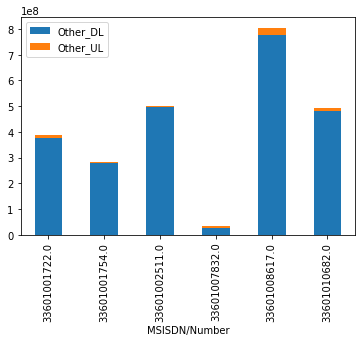

In [199]:
axis = UL_DL_per_app[["Other_DL", "Other_UL"]].plot(kind="bar", stacked=True)
fig = axis.get_figure()

In [149]:
#Aggregate by the total data volume (in Bytes) during this session for each application for each user
data_per_app=app_data.groupby(["MSISDN/Number","Bearer Id"]).agg(Youtube=("Youtube",sum),
                                         Social_Media=("Social Media",sum),
                                         Google=("Google",sum),
                                         Email=("Email",sum),
                                         Netflix=("Netflix",sum),
                                         Gaming=("Gaming",sum),
                                         Other=("Other",sum)).head(6)
data_per_app

Youtube  Social_Media   Google   Email  \
MSISDN/Number Bearer Id                                                      
33601001722   13114483554762799104 21624548       2232135  4389005 1331362   
33601001754   7349883260786089984  12432223       2660565  5334863 3307781   
33601002511   7349883263388680192  21333570       3195623  3443126 3205380   
33601007832   13042425972781099008  6977321        280294  9678493 2284670   
33601008617   7277825655840339968  20492482       1524057 10170635 1413685   
              7349883249878580224  21040520       1388485  8328981 1891784   

                                    Netflix    Gaming     Other  
MSISDN/Number Bearer Id                                          
33601001722   13114483554762799104 27180981 812458661 386570872  
33601001754   7349883260786089984  11221763 119750078 281710071  
33601002511   7349883263388680192  19353900 538827713 501693672  
33601007832   13042425972781099008  1942092 391126127  35279702  
33601008617   7277825655840339968  21973110 802565189  85988660  
              7349883249878580224  27228614 512232631 718815824

# Task 1.2

In [132]:
#Obtaining the mean, median and standard deviation of the aggregated datasets
pd.DataFrame([["xDR_seesion_count",sessions_per_user["Bearer Id"].mean(),sessions_per_user["Bearer Id"].median(),
               sessions_per_user["Bearer Id"].std()],["Duration_per_user",duration_per_user["Dur. (ms)"].mean(),
            duration_per_user["Dur. (ms)"].median(),duration_per_user["Dur. (ms)"].std()],
              ["Upload_Data",data_per_user["Total_UL"].mean(),data_per_user["Total_UL"].median(),
               data_per_user["Total_UL"].std()],
             ["Download_Data",data_per_user["Total_DL"].mean(),data_per_user["Total_DL"].median(),
               data_per_user["Total_DL"].std()],
             ["Youtube Data",data_per_app["Youtube"].mean(),data_per_app["Youtube"].median(),data_per_app["Youtube"].std()],
             ["Social Media Data",data_per_app["Social_Media"].mean(),data_per_app["Social_Media"].median(),data_per_app["Social_Media"].std()],
             ["Google Data",data_per_app["Google"].mean(),data_per_app["Google"].median(),data_per_app["Google"].std()],
             ["Email Data",data_per_app["Email"].mean(),data_per_app["Email"].median(),data_per_app["Email"].std()],
             ["Netflix Data",data_per_app["Netflix"].mean(),data_per_app["Netflix"].median(),data_per_app["Netflix"].std()],
             ["Gaming Data",data_per_app["Gaming"].mean(),data_per_app["Gaming"].median(),data_per_app["Gaming"].std()],
             ["Other Data",data_per_app["Other"].mean(),data_per_app["Other"].median(),data_per_app["Other"].std()]],
              columns=['variable','mean','median','std'])

,variable,mean,median,std
0,xDR_seesion_count,230,17,478
1,Duration_per_user,25577586,9966898,31431553
2,Upload_Data,9556574698,703478581,19833681160
3,Download_Data,105099897395,7811295382,217782136609
4,Youtube Data,23041298,21479059,13002247
5,Social Media Data,2512345,2786554,1212387
6,Google Data,9434706,7506678,6234893
7,Email Data,3547210,3255424,2246710
8,Netflix Data,23202660,23267440,16448328
9,Gaming Data,614766031,525231750,410020721


In [173]:
pd.DataFrame([["xDR_seesion_count",sessions_per_user["Bearer Id"].mean(),sessions_per_user["Bearer Id"].min(),
               sessions_per_user["Bearer Id"].max(),sessions_per_user["Bearer Id"].median(),sessions_per_user["Bearer Id"].quantile(0.25),
               sessions_per_user["Bearer Id"].quantile(0.75)],
              ["Duration_per_user",duration_per_user["Dur. (ms)"].mean(),
            duration_per_user["Dur. (ms)"].min(),duration_per_user["Dur. (ms)"].max(),duration_per_user["Dur. (ms)"].median(),
               duration_per_user["Dur. (ms)"].quantile(0.25),duration_per_user["Dur. (ms)"].quantile(0.75),],
              ["Upload_Data",data_per_user["Total_UL"].mean(),data_per_user["Total_UL"].min(),
               data_per_user["Total_UL"].max(),data_per_user["Total_UL"].median(),data_per_user["Total_UL"].quantile(0.25),
               data_per_user["Total_UL"].quantile(0.75)],
             ["Download_Data",data_per_user["Total_DL"].mean(),data_per_user["Total_DL"].min(),
               data_per_user["Total_DL"].max(),data_per_user["Total_DL"].median(),data_per_user["Total_DL"].quantile(0.25),data_per_user["Total_DL"].quantile(0.75)],
             ["Youtube Data",data_per_app["Youtube"].mean(),data_per_app["Youtube"].min(),data_per_app["Youtube"].max(),data_per_app["Youtube"].median(),
             data_per_app["Youtube"].quantile(0.25),data_per_app["Youtube"].quantile(0.75)],
             ["Social Media Data",data_per_app["Social_Media"].mean(),data_per_app["Social_Media"].min(),data_per_app["Social_Media"].max(),
             data_per_app["Social_Media"].median(),data_per_app["Social_Media"].quantile(0.25),data_per_app["Social_Media"].quantile(0.75)],
             ["Google Data",data_per_app["Google"].mean(),data_per_app["Google"].min(),data_per_app["Google"].max(),
             data_per_app["Google"].median(),data_per_app["Google"].quantile(0.25),data_per_app["Google"].quantile(0.75)],
             ["Email Data",data_per_app["Email"].mean(),data_per_app["Email"].min(),data_per_app["Email"].max(),
             data_per_app["Email"].median(),data_per_app["Email"].quantile(0.25),data_per_app["Email"].quantile(0.75)],
             ["Netflix Data",data_per_app["Netflix"].mean(),data_per_app["Netflix"].median(),data_per_app["Netflix"].std(),
             data_per_app["Netflix"].median(),data_per_app["Netflix"].quantile(0.25),data_per_app["Netflix"].quantile(0.75)],
             ["Gaming Data",data_per_app["Gaming"].mean(),data_per_app["Gaming"].min(),data_per_app["Gaming"].max(),
             data_per_app["Gaming"].median(),data_per_app["Gaming"].quantile(0.25),data_per_app["Gaming"].quantile(0.75)],
             ["Other Data",data_per_app["Other"].mean(),data_per_app["Other"].min(),data_per_app["Other"].max(),
             data_per_app["Other"].median(),data_per_app["Other"].quantile(0.25),data_per_app["Other"].quantile(0.75)]],
              columns=['variable','mean','min','max','2Q','1Q','3Q'])

,variable,mean,min,max,2Q,1Q,3Q
0,xDR_seesion_count,230,15,1084,17,16,17
1,Duration_per_user,25577586,8744914,81342932,9966898,9279434,18553754
2,Upload_Data,9556574698,624260321,45036074209,703478581,689483001,729577380
3,Download_Data,105099897395,7081602462,494679802296,7811295382,7770043342,8156743493
4,Youtube Data,17316777,6977321,21624548,20766501,14447288,21260308
5,Social Media Data,1880193,280294,3195623,1878096,1422378,2553458
6,Google Data,6890850,3443126,10170635,6831922,4625470,9341115
7,Email Data,2239110,1331362,3307781,2088227,1533210,2975202
8,Netflix Data,18150077,20663505,9906989,20663505,13254797,25879013
9,Gaming Data,529493400,119750078,812458661,525530172,421402753,736630820


# Graphical Univariate Analysis

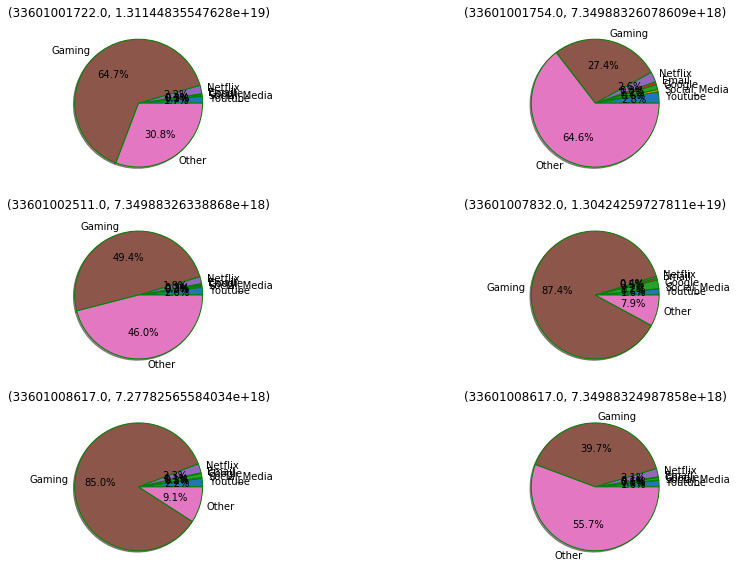

In [159]:
#data_per_app.T.plot.pie(subplots=True, figsize=(11, 6))
#Pie chart showing data usage for six random users
wp = { 'linewidth' : 1, 'edgecolor' : "green" }

fig = plt.figure(figsize=(15,10))

for i, (name, row) in enumerate(data_per_app.iterrows()):
    ax = plt.subplot(3,2, i+1)
    ax.set_title(row.name)
    ax.set_aspect('equal')
    ax.pie(row, labels=row.index,
                                  shadow = True,autopct='%1.1f%%',
                                  wedgeprops = wp,
                                  textprops = dict(color ="black"))

plt.show()


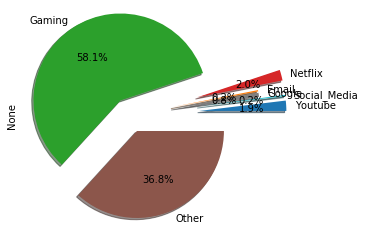

In [186]:
#pie chart showing which application uses the most data
explode = [0.8, 0.8, 0.5, 0.5, 0.8,0.2,0.2]
colors = ['tab:blue', 'tab:cyan', 'tab:gray', 'tab:orange', 'tab:red', 'tab:green','tab:brown']

data_per_app[data_per_app.columns[0:]].sum().plot.pie(shadow = True,autopct='%1.1f%%', colors = colors, explode = explode)

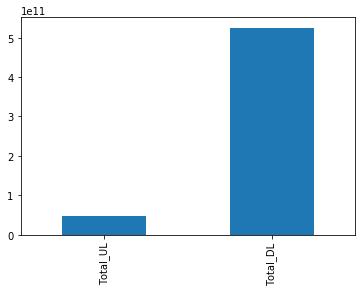

In [163]:
#Bar chart comparing Total download and Total upload
data_per_user[data_per_user.columns[1:]].sum().plot.bar()

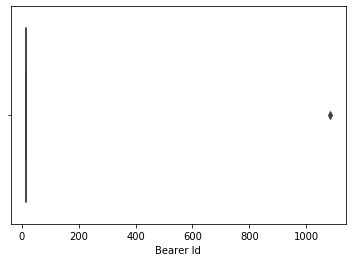

In [187]:
#Boxplot to show position of outliers in count of sessions
sns.boxplot(sessions_per_user['Bearer Id'])

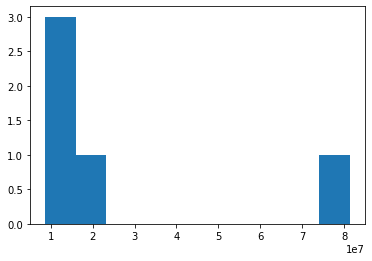

In [188]:
#Histogram of duration spent in the sessions
plt.hist(duration_per_user['Dur. (ms)'])
plt.show()

In [ ]:
#Bivariate Analysis using scatter plot


In [ ]:
#Variable Transformation

The correlation matrix indicates whether any relationship exists between the variables and the strength of that relationship.
In this case we would be looking at whether an increase in the data used in one application affects data used in another application. For example the relationship between data used in google versus data used in social media is a strong negative one. That means an increase in data used in google means less data will be used on social media.
The heatmap gives a good visual representation of the strength of the relationships, the lighter the colour the more positive the relationship and the darker the colour the more negative the relationship.

In [172]:
#Correlation analysis
corr = data_per_app.corr()

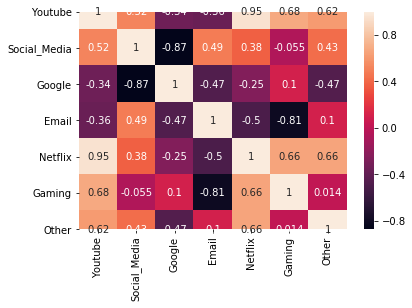

In [170]:
ax = sns.heatmap(corr, annot=True)

In [ ]:
#Dimensionality Reduction